In [1]:
import math
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F

In [2]:
class CustomSignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Save the input for backward computation
        ctx.save_for_backward(input)
        # Output +1 for input > 0, else -1 (including for input == 0)
        return torch.where(input > 0, torch.tensor(1.0, device=input.device), torch.tensor(-1.0, device=input.device))

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve the input saved in the forward pass
        input, = ctx.saved_tensors
        # Gradient of the input is the same as the gradient output (STE)
        grad_input = grad_output.clone()
        # Pass the gradient only where input was non-zero, otherwise set it to 0
        grad_input[input.abs() > 0] = grad_output[input.abs() > 0]
        return grad_input

# Wrapper class for convenience
class CustomSignActivation(torch.nn.Module):
    def __init__(self):
        super(CustomSignActivation, self).__init__()

    def forward(self, input):
        return CustomSignFunction.apply(input)

# Example usage:
sign_activation = CustomSignActivation()

# Test the forward pass
x = torch.tensor([2.0, -3.0, 0.0, 1.5], requires_grad=True)
output = sign_activation(x)
print("Output during inference:", output)

# Test the backward pass (gradient computation during training)
loss = output.sum()  # Just an example loss
loss.backward()
print("Gradient during training:", x.grad)

Output during inference: tensor([ 1., -1., -1.,  1.], grad_fn=<CustomSignFunctionBackward>)
Gradient during training: tensor([1., 1., 1., 1.])


In [3]:
class BiKALinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BiKALinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features, in_features))
        self.sign = CustomSignActivation()
            
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        # Expand the input to match the bias shape for broadcasting
        # x is of shape (batch_size, in_features)
        # Expand bias matrix to (batch_size, out_features, in_features)
        x = x.unsqueeze(1) + self.bias.unsqueeze(0)
        
        # Perform element-wise multiplication with weights
        x = x * self.weight.unsqueeze(0)
        
        # Apply sign function: -1 for negative and 0, 1 for positive
        x = self.sign(x)
        
        # Sum the thresholded products along the input features dimension
        x = torch.sum(x, dim=-1) 

        return x

# Example usage
bika_linear = BiKALinear(in_features=2, out_features=3)
input_tensor  = torch.randn(3, 2)  # Batch of 3, 10 input features each
output_tensor = bika_linear(input_tensor)

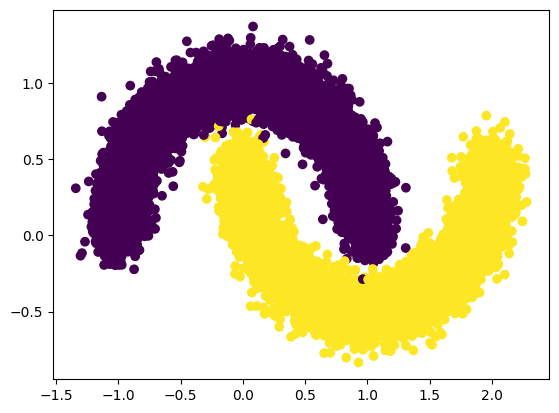

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Generate the dataset
X, y = make_moons(n_samples=16384, shuffle=True, noise=0.1, random_state=None)

device = torch.device('cpu')
dataset = {}
dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(X).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(y[:,None]).type(dtype).to(device)
plt_X = dataset['train_input']
plt_y = dataset['train_label']
plt.scatter(plt_X[:,0].cpu().detach().numpy(), plt_X[:,1].cpu().detach().numpy(), c=plt_y[:,0].cpu().detach().numpy())

# Step 2: Preprocess the dataset (optional but recommended)
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Standardize features

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create a custom PyTorch Dataset
class MoonsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # For classification use long tensor

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Step 5: Instantiate Dataset and DataLoader
train_dataset = MoonsDataset(X_train, y_train)
test_dataset = MoonsDataset(X_test, y_test)

# Step 6: Use DataLoader to load the data in batches
data_loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# Setting seeds for reproducibility
torch.manual_seed(0)

class BiKA_MOON(Module):
    def __init__(self):
        super(BiKA_MOON, self).__init__()
        
        self.fc0   = BiKALinear(in_features=2, out_features=1024)
        self.drop  = nn.Dropout(p=0.2)
        self.out   = BiKALinear(in_features=1024, out_features=2)

    def forward(self, x):
        out = self.drop(self.fc0(x))
        out = self.out(out)
        return out
   
model = BiKA_MOON()

In [6]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        #inputs, target = inputs.cuda(), target.cuda()
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [7]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            #inputs, target = inputs.cuda(), target.cuda()
            inputs, target = Variable(inputs),Variable(target)
            output = model(inputs)
            #output = torch.sigmoid(output_orig)  
            _,pred = torch.max(output,1)
            # compare against a threshold of 0.5 to generate 0/1
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [8]:
num_epochs = 100
learn_rate = 0.0001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [9]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange
from torch.autograd import Variable

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 2.039266 test accuracy = 0.960024: 100%|█| 100/100 [01:06<00:00,


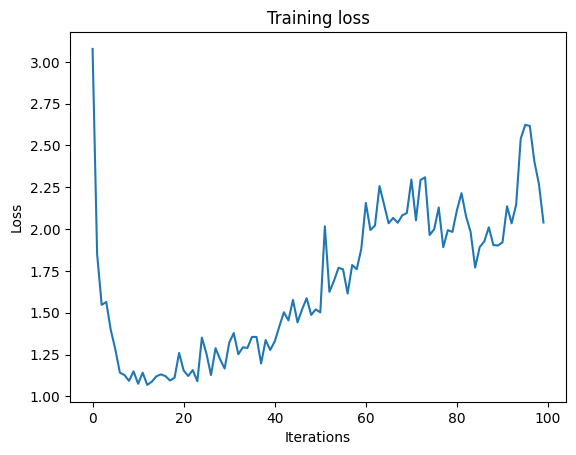

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

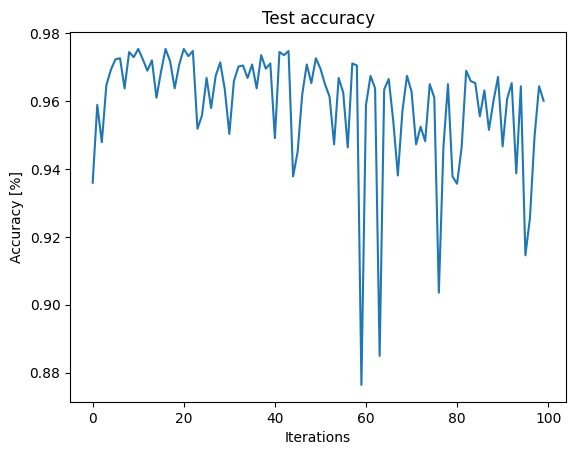

In [12]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

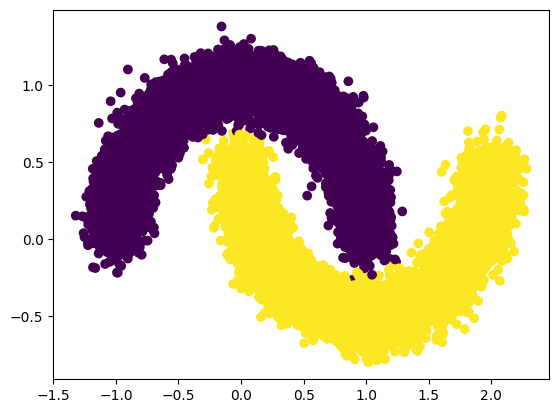

In [17]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=16384, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=16384, shuffle=True, noise=0.5, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())


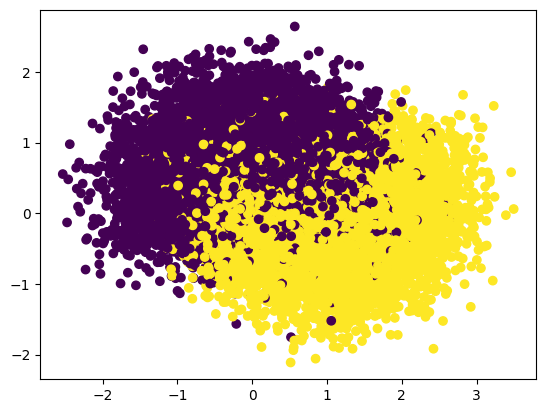

In [18]:
X = dataset['test_input']
y = dataset['test_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

In [19]:
model = KAN(width=[2,2], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.01e-02 | test_loss: 2.53e+00 | reg: 2.19e+02 | : 100%|█| 20/20 [00:02<00:00,  9.83it

saving model version 0.1


Train accuracy: [0.99951171875, 0.99957275390625, 0.99957275390625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.9996337890625, 0.99969482421875, 0.99969482421875, 0.99969482421875]
Test accuracy: 75.44%
total number of parameters: 84


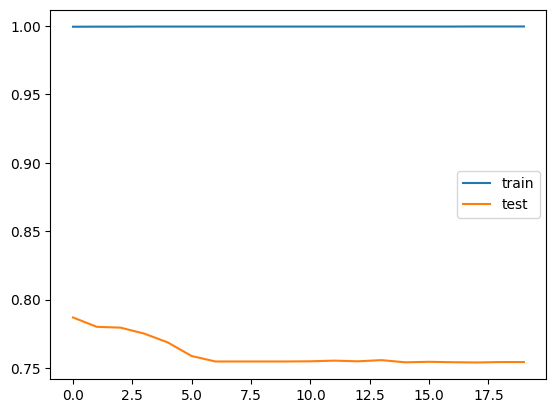

In [20]:
acc = test_acc()
print(f"Train accuracy:", results["train_acc"])
print(f"Test accuracy: {acc.item() * 100:.2f}%")
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params}")

plt.plot(results["train_acc"], label="train")
plt.plot(results["test_acc"], label="test")
plt.legend()